# Introduction

The goal of this notebook is to explore whether movies generally have been getting longer in recent years, and to try to understand why and how movie lengths have been changing across the industry.

# Importing Data and Python Packages

This entire section can be collapsed to skip just to the narrative and visualizations.

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
df_movies = pd.read_csv('movies.csv')

df_movies.shape

(941597, 7)

Let's drop rows with missing entries. We can also limit out analysis to 2023 and earlier to avoid movies that have not been released yet.

In [3]:
df_movies = df_movies[~df_movies['date'].isna()]
df_movies = df_movies[~df_movies['minute'].isna()]
df_movies = df_movies[df_movies['date'] < 2024]
df_movies = df_movies.astype({"date": int, "minute": int})

df_movies.head()

,id,name,date,tagline,description,minute,rating
0,1000001,Barbie,2023,She's everything. He's just Ken.,Barbie and Ken are having the time of their li...,114,3.86
1,1000002,Parasite,2019,Act like you own the place.,"All unemployed, Ki-taek's family takes peculia...",133,4.56
2,1000003,Everything Everywhere All at Once,2022,The universe is so much bigger than you realize.,An aging Chinese immigrant is swept up in an i...,140,4.30
3,1000004,Fight Club,1999,Mischief. Mayhem. Soap.,A ticking-time-bomb insomniac and a slippery s...,139,4.27
4,1000005,La La Land,2016,Here's to the fools who dream.,"Mia, an aspiring actress, serves lattes to mov...",129,4.09


In [4]:
df_studios = pd.read_csv('studios.csv')
df_genres = pd.read_csv('genres.csv')

## Building a Dataframe

Let's build a dataframe containing the information we would like to explore. We start by limiting ourselves to feature-length movies, which we'll say are at least an hour long, and also to movies under 5 hours in order to eliminate most of the TV series which are unfortunately included in the dataset. Additionally, we only consider movies released starting in 1920, since there is limited data before then.

In [5]:
feature_movies = df_movies[(df_movies['minute'] >= 60) & (df_movies['minute'] < 300) & (df_movies['date'] >= 1920)]

feature_movies.shape[0]

367876

In [6]:
biggest_studios = df_studios['studio'].value_counts(sort=True).head(20)

biggest_studios

studio
BBC                      3560
Warner Bros. Pictures    3222
Columbia Pictures        3000
ARTE                     2824
Metro-Goldwyn-Mayer      2789
ONF | NFB                2662
Universal Pictures       2633
Paramount                2627
ZDF                      2569
Toei Company             2360
Nikkatsu Corporation     1878
20th Century Fox         1693
ARD                      1601
Mosfilm                  1521
Canal+                   1488
Česká televize           1366
TOHO                     1314
Shochiku                 1303
RKO Radio Pictures       1209
France Télévisions       1187
Name: count, dtype: int64

Although there likely other Hollywood and big-budget studios not in the following list, this should give us a good representation to see trends specific to Hollywood.

In [7]:
hollywood_studios = ['Warner Bros. Pictures', 'Columbia Pictures', 'Metro-Goldwyn-Mayer', 'Universal Pictures', 'Paramount', '20th Century Fox']

Let's create a column designating whether a movie was created by one of these six hollywood studios.

In [8]:
df_studios['is_hollywood'] = df_studios['studio'].isin(hollywood_studios).astype(int)
movies_by_hollywood = df_studios.groupby('id').agg(is_hollywood=('is_hollywood', 'sum')).astype(bool)
merged_df = feature_movies.merge(movies_by_hollywood, on='id', how='inner', validate='one_to_one')

Now let's incorporate genre information.

In [9]:
df_genres['genre'].unique()

array(['Comedy', 'Adventure', 'Thriller', 'Drama', 'Science Fiction',
       'Action', 'Music', 'Romance', 'History', 'Crime', 'Animation',
       'Mystery', 'Horror', 'Family', 'Fantasy', 'War', 'Western',
       'TV Movie', 'Documentary'], dtype=object)

The df_genres dataframe is in long format, so we one-hot encode its information before merging it into our existing merged_df. We also drop rows which are documentaries or TV movies.

In [10]:
merged_genres = df_genres.merge(pd.get_dummies(df_genres['genre']).astype(int), how='inner', left_index=True, right_index=True)
one_hot_genres = merged_genres.groupby('id').sum().astype(bool).drop('genre', axis=1)
merged_again = merged_df.merge(one_hot_genres, how='inner', on='id')
non_tv_fiction = merged_again[(merged_again['Documentary'] == False) & (merged_again['TV Movie'] == False)]

In [11]:
non_tv_fiction.head()

,id,name,date,tagline,description,minute,rating,is_hollywood,Action,Adventure,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,1000001,Barbie,2023,She's everything. He's just Ken.,Barbie and Ken are having the time of their li...,114,3.86,True,False,True,...,False,False,False,False,False,False,False,False,False,False
1,1000002,Parasite,2019,Act like you own the place.,"All unemployed, Ki-taek's family takes peculia...",133,4.56,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,1000003,Everything Everywhere All at Once,2022,The universe is so much bigger than you realize.,An aging Chinese immigrant is swept up in an i...,140,4.30,False,True,True,...,False,False,False,False,False,True,False,False,False,False
3,1000004,Fight Club,1999,Mischief. Mayhem. Soap.,A ticking-time-bomb insomniac and a slippery s...,139,4.27,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1000005,La La Land,2016,Here's to the fools who dream.,"Mia, an aspiring actress, serves lattes to mov...",129,4.09,False,False,False,...,False,False,True,False,True,False,False,False,False,False


In [12]:
non_tv_fiction.shape

(179875, 27)

# Plots

We now have a dataframe with nearly 180,000 rows, each containing a unique movie with release year, runtime in minutes, whether it was created by one of the our six Hollywood studios, and whether it is a given genre. Let's see what this data looks like!

## Overall Trend

To start, let's visualize the median runtime from year to year since 1920. We use seaborn's relplot in order to get a sense of the spread of the data in each year as well.

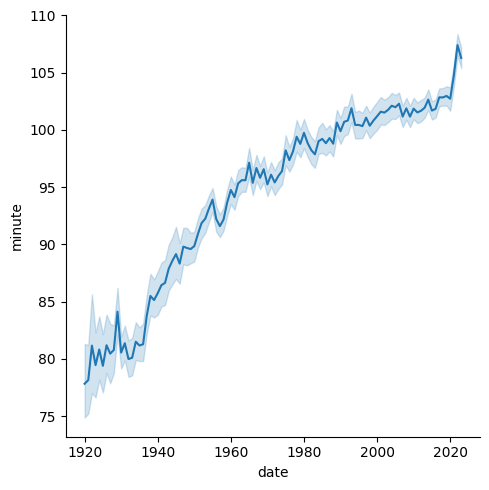

In [13]:
sns.relplot(data=non_tv_fiction, kind="line", x="date", y="minute")

Based on the above plot, movies have indeed gotten longer over time, with a particularly pronounced spike in the last couple of years. However, when people say "movies are getting longer", they are generally talking about the movies that they have heard of and might see. Looking just at Hollywood movies might give us a better sense for that.

A potential explanation for the spike in 2020 is that the outbreak of Covid-19 made it harder for shorter, low-budget movies to be made. If this were the only effect, we should expect to see the big-budget Hollywood movies with less of a spike.

## Separating Hollywood

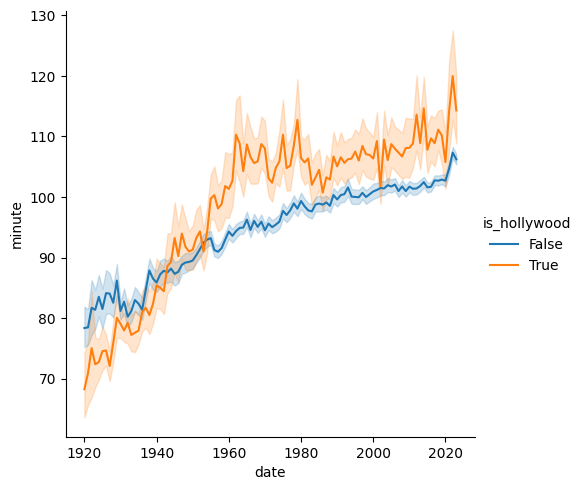

In [14]:
sns.relplot(data=non_tv_fiction, kind="line", x="date", y="minute", hue="is_hollywood")

We see in this plot that from about 1960 to 2020, the median runtime of Hollywood movies bounced around between 100 and 110 minutes, but without rising much on average. The steady rise in runtimes seems to be due to non-Hollywood movies, which rose from a median of about 92 to 102 in that period. In both categories we see the sudden spike after 2020. In fact, the Hollywood spike is even more pronounced, showing that our attempted explanation above does not work.

One interesting detail in the above plot is the significant gap between Hollywood and other movies between 1960 and 1980. A potential explanation is that while Hollywood started to make longer, more elaborate movies at that time, there was a new wave of low-budget movie-making with a more limited scope, enabled by the accessability of film-making equipment.

In reading the above plot, it is also worth keeping in mind the size of the data considered in each year.

<Axes: xlabel='date', ylabel='Count'>

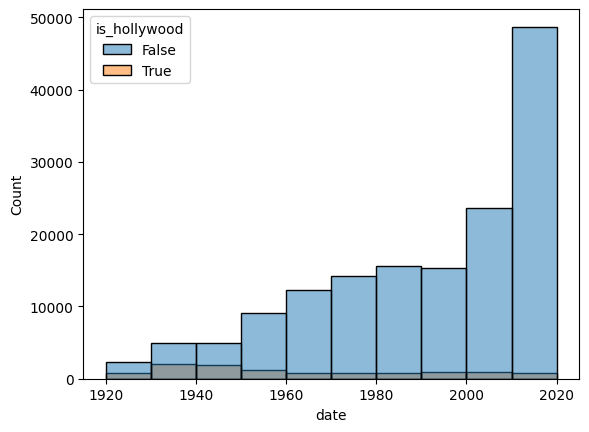

In [15]:
sns.histplot(data=non_tv_fiction, x="date", bins=[1920+10*i for i in range(11)], hue="is_hollywood")

In the 30's and 40's, nearly half of all movies were made in Hollywood, but since then the total Hollywood output has slightly declined, whereas the output from other studios has grown enormously. In particular, the boom in movies made in the past decade or two is likely due to the accessibility of digital film-making equipment as well as computer editing software. A movie like <i>Tangerine (2015)</i> underscores this point, having been shot using three iPhones and going on to earn nearly $1 million at the box office.

In the pictures below, we include the 20's through the 40's, but we will see that with the limited data before 1950, many of the subsets of our data have high variance from year-to-year, sometimes making the charts chaotic and hard to interpret before 1950.

## Genres

Let's finish our investigation by taking a look how a few genres have evolved over time.

### Drama

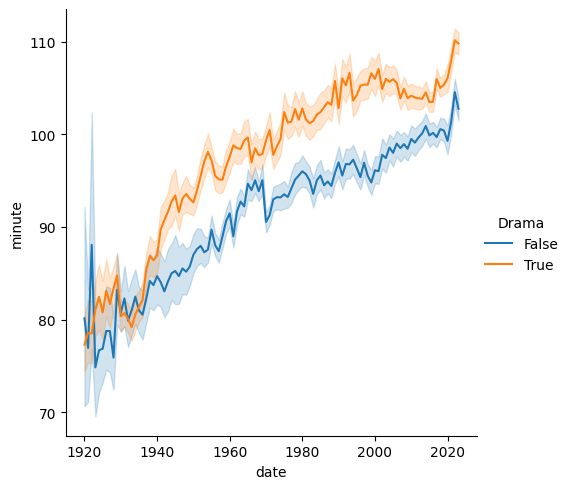

In [16]:
sns.relplot(data=non_tv_fiction, kind="line", x="date", y="minute", hue="Drama")

Perhaps unsurprisingly, movies that get classified as "drama" have tended to be longer, as they are intended to be more serious and tell more intense and elaborate stories. Otherwise, they both are roughly following the overall trend of movie lengths of any genre, including the post-2020 spike.

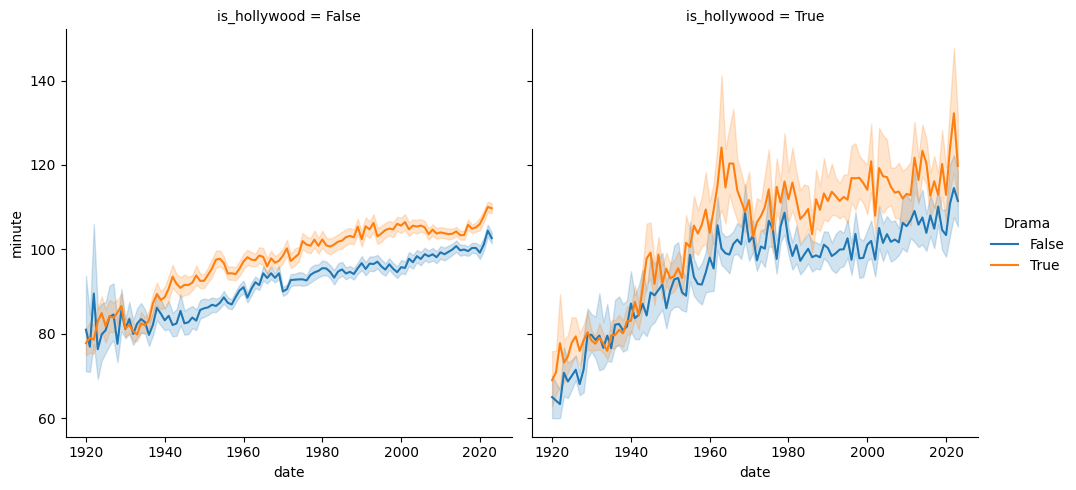

In [17]:
sns.relplot(data=non_tv_fiction, kind="line", x="date", y="minute", col="is_hollywood", hue="Drama")

The effect seems to be similar whether a movie is Hollywood or not.

### Comedy

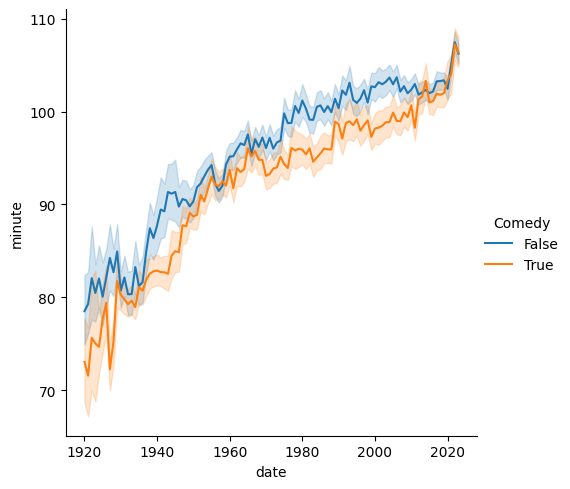

In [18]:
sns.relplot(data=non_tv_fiction, kind="line", x="date", y="minute", hue="Comedy")

For comedies, we see the opposite effect as for dramas, where comedies tend to be shorter. However, the effect is not as pronounced, and has even seemed to disappear in recent years. A potential explanation for this is that many more movies that are classified as "comedy" are not just straightforward joke/gag vehicles, but incorporating more elements of drama.

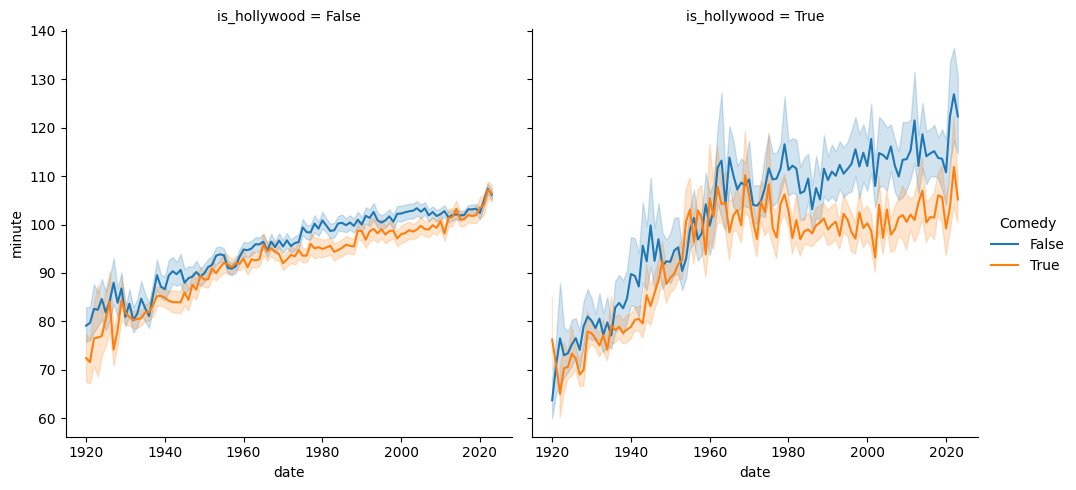

In [19]:
sns.relplot(data=non_tv_fiction, kind="line", x="date", y="minute", col="is_hollywood", hue="Comedy")

When we separate out the six Hollywood studios, we see that in Hollywood the effect has been much stronger, and has apparently not diminished at all in recent years. This observation lends weight to the above conjecture, as Hollywood studios have probably stuck to a more traditional formula for their comedies.

### Horror

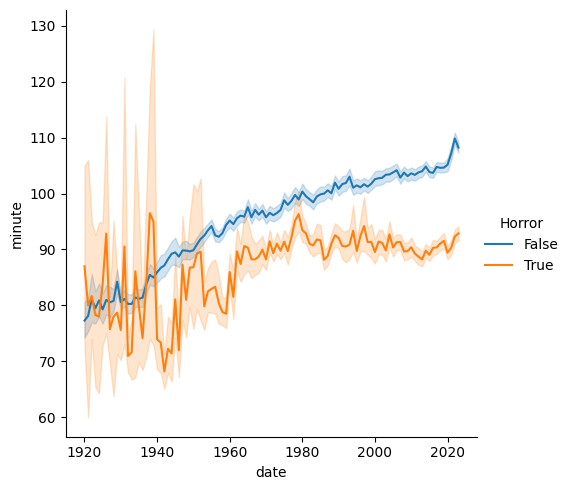

In [20]:
sns.relplot(data=non_tv_fiction, kind="line", x="date", y="minute", hue="Horror")

Horror is an interesting genre to explore because it has always had a reputation as being less serious, perhaps even more so than comedy, and we indeed see a much more pronounced difference between horror and non-horror.

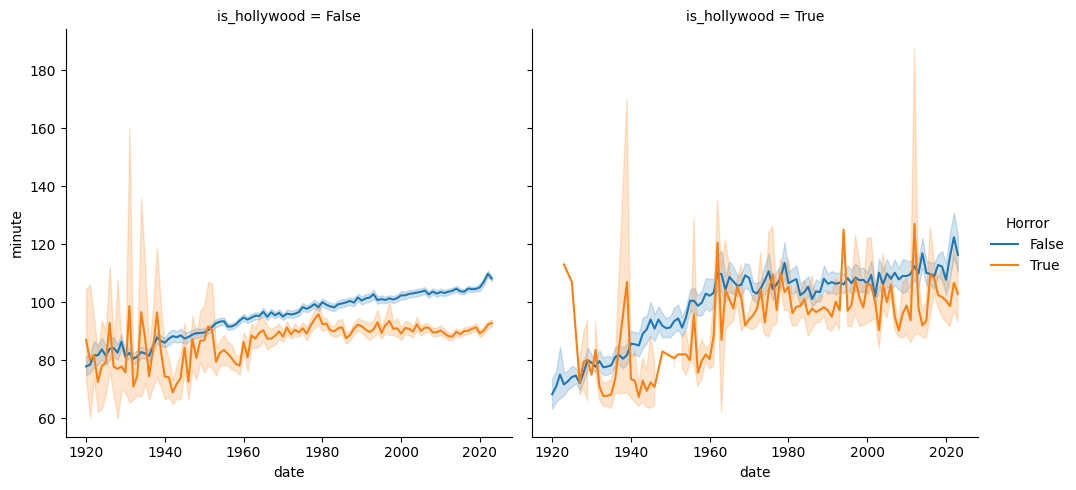

In [21]:
sns.relplot(data=non_tv_fiction, kind="line",x="date",y="minute",col="is_hollywood",hue="Horror")

Unlike comedy, we see that this difference is the same or less in Hollywood movies than not. In fact, let's compare Hollywood vs not for just horror.

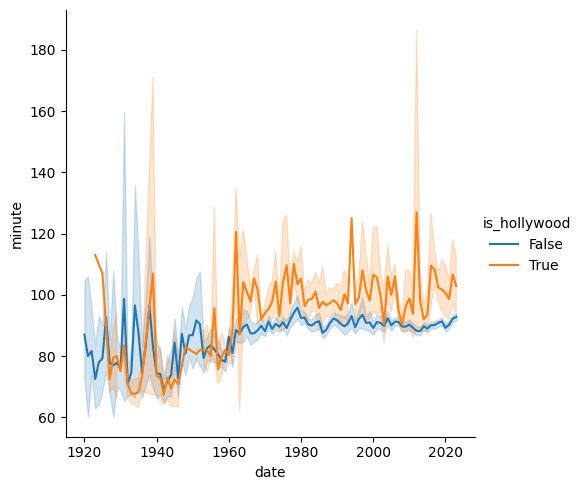

In [22]:
sns.relplot(data=non_tv_fiction[non_tv_fiction['Horror'] == True], kind="line",x="date",y="minute",hue="is_hollywood")

Despite the high variance due to limited data for Hollywood horror movies, we see a relatively steady trend since 1960, with Hollywood horror tending to last around 100 minutes and non-Hollywood tending to be around 90 minutes. In both cases, there does not even appear to be a post-2020 spike! These observations may not be surprising, since horror is known as a genre with a formula that has not evolved much over time.

### War

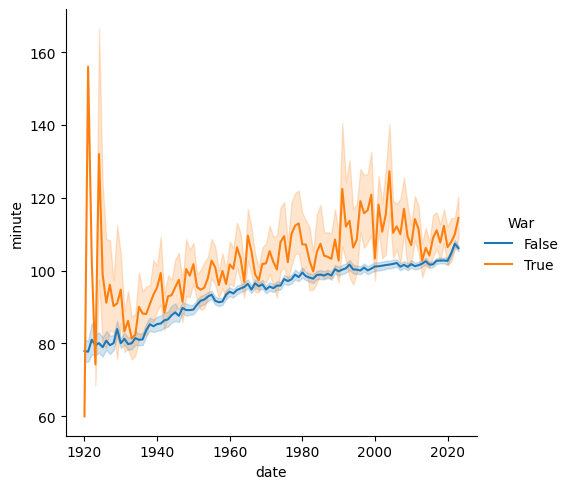

In [23]:
sns.relplot(data=non_tv_fiction, kind="line", x="date", y="minute", hue="War")

For war movies, we see a similar effect as for drama, where the severity of the topic tends to require a more developed story.

# Conclusion

We've seen that movies have tended to be longer as time has gone on, with a peculiar spike around 2020. Although we found various insights into the ways that different genres and movie studios have evolved over time, we still see that same spike across all of the breakdowns we looked at, except for possibly horror.

An avenue for future investigation in this dataset would be to dig in to the releases.csv file, in order to understand if there were any changes in how and when movies were released due to Covid-19. It would also allow us to separate out movies that received a legitimate theatrical release, as there may still be a number of TV shows and amateur or unreleased skewing the current data.

The best option to gain a better understanding of the spike after 2020 is probably to look into other datasets with more robust production and budget details. In particular, it would be interesting to see if the spike is observable across all budget levels.